# Inference with Makani 

There are currently two ways to inference models trained in Makani: `model_package` and `inferencer`. Let us start by adding Makani to our path.

In [1]:
import os, sys

makani_home = "../"
sys.path.append(makani_home)

## Using Model Package

In [2]:
from modulus.experimental.sfno.networks.model_package import LocalPackage, load_model_package

path_to_package = os.path.expanduser("~/Projects/fourcastnet/climate_fno/CWO-data/73VarQ/runs/sfno_linear_73chq_sc3_layers8_edim384_asgl2_cadam/ngpu64_sp1")

load_model_package(LocalPackage(path_to_package))

ModelWrapper(
  (model): SingleStepWrapper(
    (preprocessor): Preprocessor2D()
    (model): SphericalFourierNeuralOperatorNet(
      (trans_down): RealSHT(
        nlat=721, nlon=1440,
         lmax=240, mmax=241,
         grid=equiangular, csphase=True
      )
      (itrans_up): InverseRealSHT(
        nlat=721, nlon=1440,
         lmax=240, mmax=241,
         grid=equiangular, csphase=True
      )
      (trans): RealSHT(
        nlat=240, nlon=480,
         lmax=240, mmax=241,
         grid=legendre-gauss, csphase=True
      )
      (itrans): InverseRealSHT(
        nlat=240, nlon=480,
         lmax=240, mmax=241,
         grid=legendre-gauss, csphase=True
      )
      (encoder): EncoderDecoder(
        (fwd): Sequential(
          (0): Conv2d(109, 384, kernel_size=(1, 1), stride=(1, 1))
          (1): GELU(approximate='none')
          (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
      )
      (pos_drop): Identity()
      (blocks): ModuleList(
  

## Using Inferencer

The inferencer module is designed for running models directly within Makani. It supports massively parallel autoregressive roll-outs, ensemble forecasting and scoring. However, it's setup is slightly more involved.

To instantiate `inferencer`, we require the `params` datastructure. Thankfully, we can either use the model package for this or alternatively, use the configuration with which the model was trained.

When using inferencer, a dataloader for inference is created. As such, we recommend the latter method and manually setting the path to the out-of-sample dataset:

In [3]:
from modulus.experimental.sfno.utils.YParams import YParams

yaml_config = os.path.join(makani_home, "config/sfnonet_devel.yaml")
config =  "sfno_linear_73chq_sc3_layers8_edim384_asgl2_cadam"
run_num = "ngpu64_sp1"

params = YParams(yaml_config, config)

let us set some extra parameters necessary for experimentation. Paths need to be adjusted but these can all be set to use the paths from the `model_package`. A lot of this is boilerplate and a rework is in progress to avoid all of this.

In [4]:
import torch
torch.backends.cudnn.benchmark = True

from modulus.experimental.sfno.utils.parse_dataset_metada import parse_dataset_metadata

# point it to the training data
data_dir = '/home/bbonev/Projects/fourcastnet/climate_fno/CWO-data/73VarQ/'

# setting the necessary paths
params['inf_data_path'] = os.path.join(data_dir, 'out_of_sample/') # dataset to use for inference
params['experiment_dir'] = os.path.join(data_dir, 'runs/', config, run_num) # directory for writing out results
params['checkpoint_path'] = os.path.join(params.experiment_dir, 'training_checkpoints/ckpt_mp0.tar') # last checkpoint
params['best_checkpoint_path'] = os.path.join(params.experiment_dir, 'training_checkpoints/best_ckpt_mp0.tar') # best checkpoint
params['metadata_json_path'] = os.path.join(data_dir, 'invariants/data.json') # data.json file - see README for detailed info

# where to find normalization 
params['min_path'] = os.path.join(data_dir, 'stats/mins.npy')
params['max_path'] = os.path.join(data_dir, 'stats/maxs.npy')
params['time_means_path'] = os.path.join(data_dir, 'stats/time_means.npy')
params['global_means_path'] = os.path.join(data_dir, 'stats/global_means.npy')
params['global_stds_path'] =  os.path.join(data_dir, 'stats/global_stds.npy')
params['time_diff_means_path'] = os.path.join(data_dir, 'stats/time_diff_means.npy')
params['time_diff_stds_path'] = os.path.join(data_dir, 'stats/time_diff_stds.npy')

# land-sea-mask and orography
params['orography_path'] = os.path.join(data_dir, 'invariants/orography.nc')
params['landmask_path'] = os.path.join(data_dir, 'invariants/land_mask.nc')

# set parameters which can be read from the metadata file
params, _ = parse_dataset_metadata(params['metadata_json_path'], params=params)

params['multifiles'] = True # use the multifiles dataloader (not DALI)
params['n_future'] = 0 # predict one step at a time
params['valid_autoreg_steps'] = 20
params['split_data_channels'] = False 

# do not log to wandb
params['log_to_wandb'] = False

In [5]:
from modulus.experimental.sfno.inference.inferencer import Inferencer

inferencer = Inferencer(params, world_rank=0)

SingleStepWrapper(
  (preprocessor): Preprocessor2D()
  (model): SphericalFourierNeuralOperatorNet(
    (trans_down): RealSHT(
      nlat=721, nlon=1440,
       lmax=240, mmax=241,
       grid=equiangular, csphase=True
    )
    (itrans_up): InverseRealSHT(
      nlat=721, nlon=1440,
       lmax=240, mmax=241,
       grid=equiangular, csphase=True
    )
    (trans): RealSHT(
      nlat=240, nlon=480,
       lmax=240, mmax=241,
       grid=legendre-gauss, csphase=True
    )
    (itrans): InverseRealSHT(
      nlat=240, nlon=480,
       lmax=240, mmax=241,
       grid=legendre-gauss, csphase=True
    )
    (encoder): EncoderDecoder(
      (fwd): Sequential(
        (0): Conv2d(109, 384, kernel_size=(1, 1), stride=(1, 1))
        (1): GELU(approximate='none')
        (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (pos_drop): Identity()
    (blocks): ModuleList(
      (0): FourierNeuralOperatorBlock(
        (inner_skip): Conv2d(384, 384, kernel_size

Let's select some channels we want to analyze:

In [6]:
output_channels = ["u10m", "v10m", "z500", "t2m"]
output_channels = [params["channel_names"].index(ch) for ch in output_channels]
output_channels

[0, 1, 41, 4]

Currently, the API provided in inferencer takes in an initial condition

In [10]:
truth, pred, _, acc_curve, rmse_curve = inferencer.inference_single(ic=0, output_data=True, output_channels=output_channels, compute_metrics=True)

BEFORE block True
BEFORE conv True
AFTER conv trans True
AFTER conv itrans True
AFTER conv True
AFTER spectral True True
AFTER Norm True
AFTER block True
BEFORE block True
BEFORE conv True
AFTER conv trans True
AFTER conv itrans True
AFTER conv True
AFTER spectral True True
AFTER Norm True
AFTER block True
BEFORE block True
BEFORE conv True
AFTER conv trans True
AFTER conv itrans True
AFTER conv True
AFTER spectral True True
AFTER Norm True
AFTER block True
BEFORE block True
BEFORE conv True
AFTER conv trans True
AFTER conv itrans True
AFTER conv True
AFTER spectral True True
AFTER Norm True
AFTER block True
BEFORE block True
BEFORE conv True
AFTER conv trans True
AFTER conv itrans True
AFTER conv True
AFTER spectral True True
AFTER Norm True
AFTER block True
BEFORE block True
BEFORE conv True
AFTER conv trans True
AFTER conv itrans True
AFTER conv True
AFTER spectral True True
AFTER Norm True
AFTER block True
BEFORE block True
BEFORE conv True
AFTER conv trans True
AFTER conv itrans T

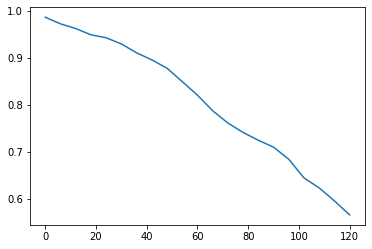

In [21]:
import matplotlib.pyplot as plt

t = torch.arange((params.valid_autoreg_steps+1))*params.dhours
plt.plot(t, acc_curve[0])
plt.show()

In [26]:
pred.shape

torch.Size([21, 1, 4, 721, 1440])

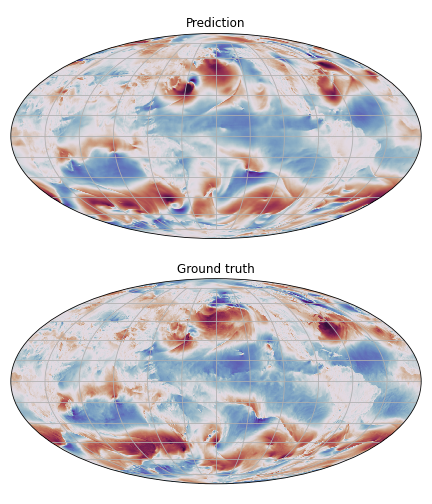

In [33]:
from modulus.experimental.sfno.utils.visualize import plot_comparison

plot_comparison(pred[-1, 0, 0], truth[-1, 0, 0], diverging=True)